In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns


In [2]:
RANDOM_STATE = 1
df = pd.read_csv("../data/clean_train.csv")
df.head(3)


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,cabin_deck,solo
0,0,lower,"braund,_mr._owen_harris",male,22.0,1,0,a/5_21171,7.2500,unknown,s,u,0
1,1,upper,"cumings,_mrs._john_bradley_(florence_briggs_th...",female,38.0,1,0,pc_17599,71.2833,c85,c,c,0
2,1,lower,"heikkinen,_miss._laina",female,26.0,0,0,ston/o2._3101282,7.9250,unknown,s,u,1


In [3]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

y_train = df_train['survived'].values
y_val = df_val['survived'].values

del df_train['survived']
del df_val['survived']

In [4]:
numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked', 'cabin_deck', 'solo']
features = numerical_features + categorical_features

# Decision Tree Classifier

In [5]:
def train(df_train, y_train, features, **model_params):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = DecisionTreeClassifier(**model_params)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, features, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [6]:
from sklearn.tree import export_text


dv, model = train(df_train, y_train, features)
y_pred = predict(df_train, dv, features, model)
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)


y_pred = predict(df_val, dv, features, model)
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

print(export_text(model, feature_names=list(dv.get_feature_names_out())))

train: 0.9998195809242492
val: 0.6875807702248643
|--- sex=male <= 0.50
|   |--- pclass=lower <= 0.50
|   |   |--- age <= 2.50
|   |   |   |--- pclass=upper <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- pclass=upper >  0.50
|   |   |   |   |--- class: 0
|   |   |--- age >  2.50
|   |   |   |--- fare <= 28.86
|   |   |   |   |--- fare <= 28.23
|   |   |   |   |   |--- sibsp <= 0.50
|   |   |   |   |   |   |--- fare <= 13.25
|   |   |   |   |   |   |   |--- fare <= 12.82
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- fare >  12.82
|   |   |   |   |   |   |   |   |--- age <= 37.00
|   |   |   |   |   |   |   |   |   |--- age <= 26.00
|   |   |   |   |   |   |   |   |   |   |--- solo <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- solo >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- age >  26.00
|   |   |   |  

In [7]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
tuning_params = {"max_depth": 1}

for depth in depths: 
    tuning_params['max_depth'] = depth
    dv, dt = train(df_train, y_train, features, **tuning_params)
    y_pred = predict(df_val, dv, features, dt)
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))



   1 -> 0.760
   2 -> 0.771
   3 -> 0.840
   4 -> 0.841
   5 -> 0.839
   6 -> 0.828
  10 -> 0.720
  15 -> 0.698
  20 -> 0.707
None -> 0.685


In [8]:
scores = []

for depth in [2, 3, 4, 5, 6]:
    for s in [1, 2, 3, 4, 5, 6, 10, 15, 20, 500, 100, 200]:
        tuning_params['max_depth'] = depth
        tuning_params['min_samples_leaf'] = s
        dv, dt = train(df_train, y_train, features, **tuning_params)
        y_pred = predict(df_val, dv, features, dt)
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))
        

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

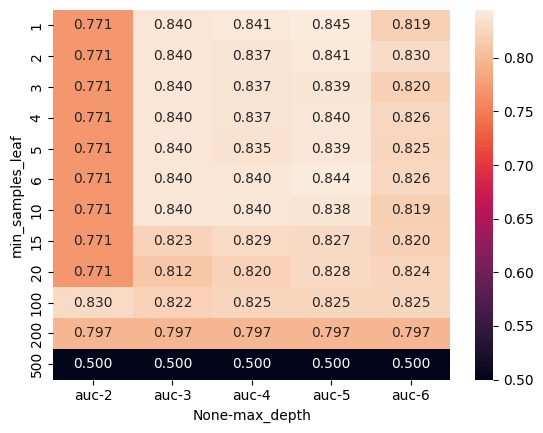

In [9]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [10]:
tuning_params['max_depth'] = 5
tuning_params['min_samples_leaf'] = 1 
dv, dt = train(df_train, y_train, features, **tuning_params)
y_pred = predict(df_val, dv, features, dt)

auc = roc_auc_score(y_val, y_pred)
print('val:', auc)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

val: 0.8445334711811838
|--- sex=female <= 0.50
|   |--- age <= 13.00
|   |   |--- sibsp <= 2.50
|   |   |   |--- solo <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- solo >  0.50
|   |   |   |   |--- class: 0
|   |   |--- sibsp >  2.50
|   |   |   |--- age <= 3.50
|   |   |   |   |--- age <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  2.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- age >  3.50
|   |   |   |   |--- class: 0
|   |--- age >  13.00
|   |   |--- cabin_deck=u <= 0.50
|   |   |   |--- fare <= 7.90
|   |   |   |   |--- class: 0
|   |   |   |--- fare >  7.90
|   |   |   |   |--- fare <= 32.25
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- fare >  32.25
|   |   |   |   |   |--- class: 0
|   |   |--- cabin_deck=u >  0.50
|   |   |   |--- pclass=upper <= 0.50
|   |   |   |   |--- age <= 32.25
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  32.25
|   |   |   |   |   |--- class: 0
|   |   |   |--- pclass=upper >  0.50
|   

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_params = {}
features = ['age', 'sex', 'pclass', 'sibsp', 'solo']

def train(df_train, y_train, features, **model_params):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = RandomForestClassifier(**model_params)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, features, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
scores = []

for n in range(10, 201, 10):
    model_params = {
        "n_estimators": n,
        "random_state": 1
    }
    dv, model = train(df_train, y_train, features, **model_params)
    y_pred = predict(df_val, dv, features, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

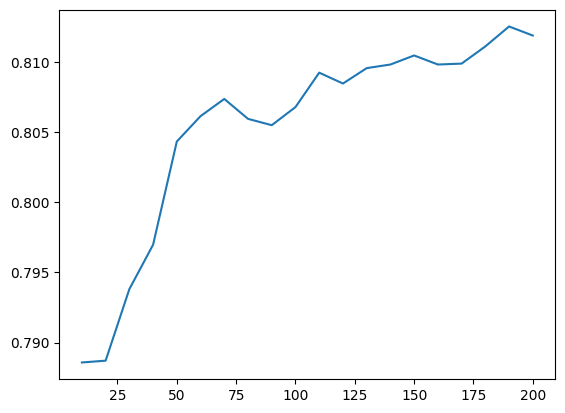

In [25]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)


In [43]:
scores = []
depth_range = range(3, 15, 3)
estimators_range = range(10, 201, 10)

for d in depth_range:
    for n in estimators_range:
        model_params = {
            "max_depth": d,
            "n_estimators": n,
            "random_state": 1
        }
        dv, model = train(df_train, y_train, features, **model_params)
        y_pred = predict(df_val, dv, features, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))



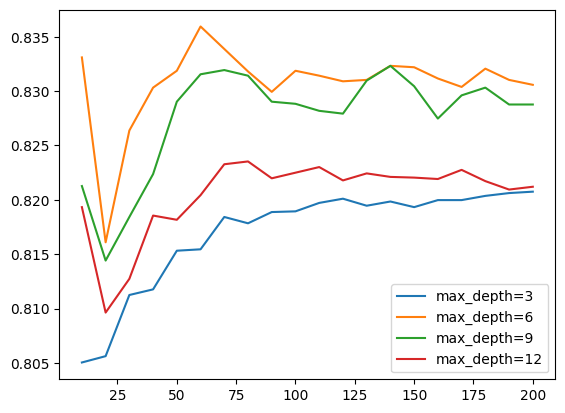

In [44]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

for d in depth_range:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
plt.legend()


In [45]:
model_params['max_depth'] = 6

In [52]:
scores = []
samples_leaf_range = [1, 2, 3, 5, 10, 50]

In [53]:
for s in samples_leaf_range:
    for n in estimators_range:
        model_params['n_estimators'] = n
        model_params['min_samples_leaf'] = s
        dv, model = train(df_train, y_train, features, **model_params)
        y_pred = predict(df_val, dv, features, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [54]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

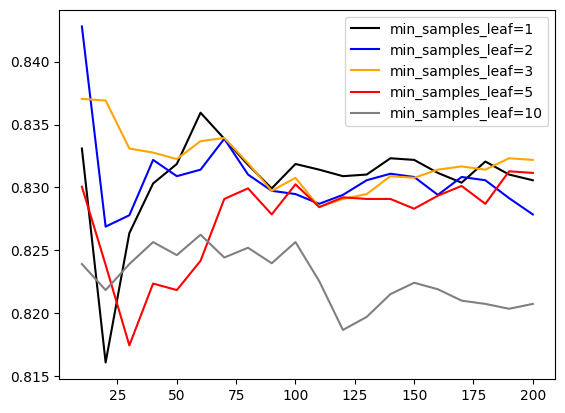

In [55]:
colors = ['black', 'blue', 'orange', 'red', 'grey']


for s, col in zip(samples_leaf_range, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [60]:
model_params['min_samples_leaf'] = 1
model_params['n_estimators'] = 60
model_params

{'max_depth': 6, 'n_estimators': 60, 'random_state': 1, 'min_samples_leaf': 1}

In [61]:
dv, model = train(df_train, y_train, features, **model_params)
y_pred = predict(df_val, dv, features, model)
auc = roc_auc_score(y_val, y_pred)
auc

0.8359395192556216